In [1]:
import pandas as pd
import matplotlib.pyplot as plt

In [2]:
datasetH = pd.read_csv('./data/[1h]BTCUSDT.csv')
datasetM = pd.read_csv('./data/[1m]BTCUSDT.csv')

In [6]:
xH = pd.to_datetime(datasetH['Stop'].to_numpy(), unit='ms').to_numpy()
yH = datasetH['Close'].to_numpy()

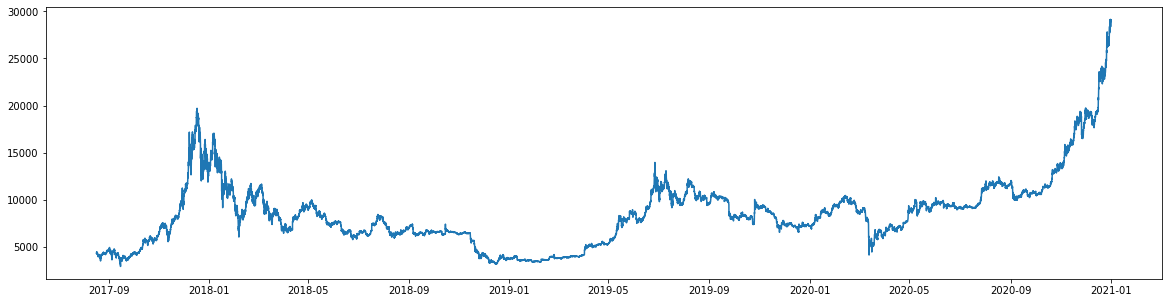

In [7]:
plt.figure(figsize=(20, 5))
plt.plot(xH, yH)

In [8]:
xM = pd.to_datetime(datasetM['Stop'].to_numpy(), unit='ms').to_numpy()
yM = datasetM['Close'].to_numpy()

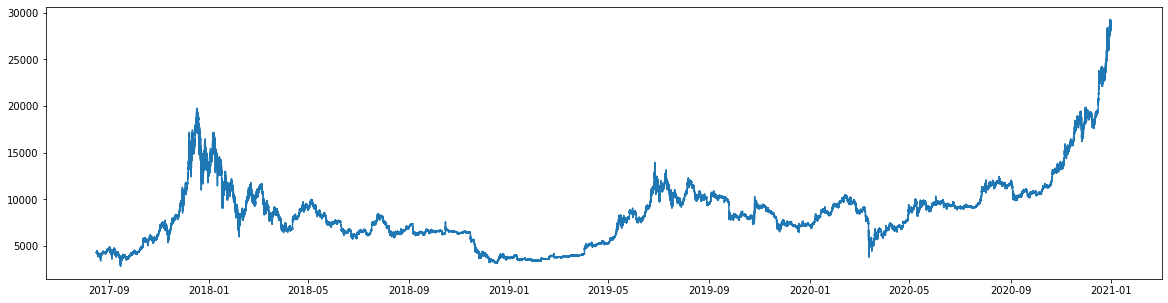

In [9]:
plt.figure(figsize=(20, 5))
plt.plot(xM, yM)

# Autoregression (AR) 


In [13]:
from statsmodels.tsa.ar_model import AutoReg

### datasetH

In [92]:
modelH = AutoReg(yH, lags=1250)
model_fit = modelH.fit()
yhatH = model_fit.predict(0, len(yH) + 1000)

c:\users\денис\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


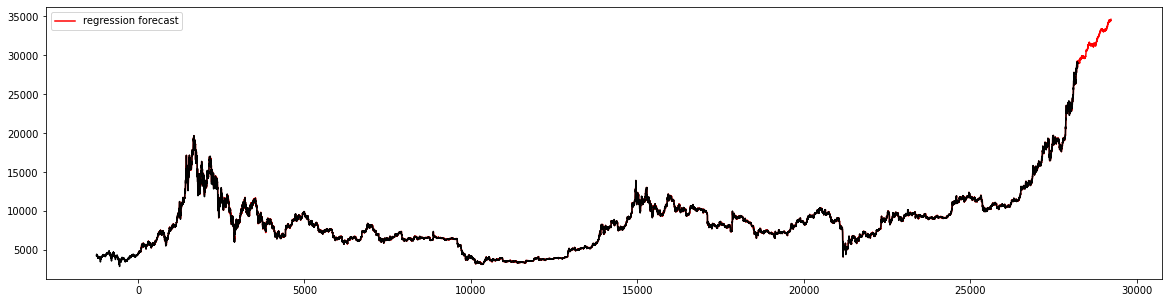

In [93]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(yhatH)), yhatH, color='red', label='regression forecast')
plt.plot(range(-1250, len(yH)-1250), yH, c='black')
plt.legend()
plt.show()

### datasetM

In [94]:
modelM = AutoReg(yM, lags=5)
model_fit = modelM.fit()
yhatM = model_fit.predict(0, len(yM) + 1000)

c:\users\денис\appdata\local\programs\python\python38\lib\site-packages\statsmodels\tsa\ar_model.py:248: FutureWarning: The parameter names will change after 0.12 is released. Set old_names to False to use the new names now. Set old_names to True to use the old names. 
  warnings.warn(


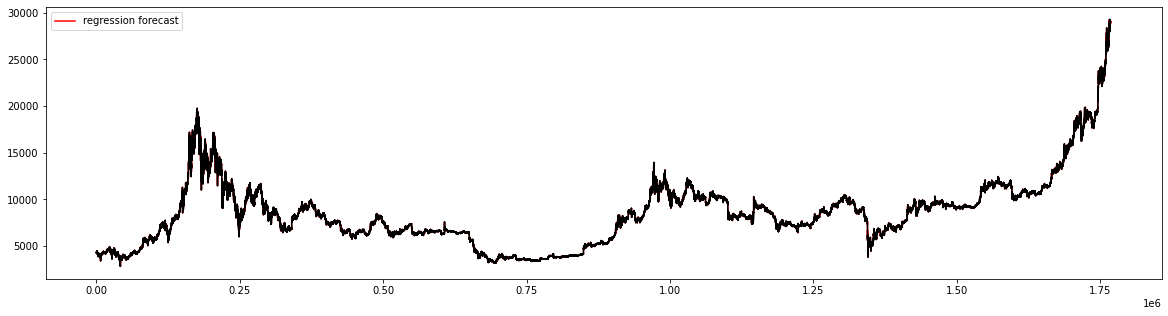

In [95]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(yhatM)), yhatM, color='red', label='regression forecast')
plt.plot(range(-5, len(yM)-5), yM, c='black')
plt.legend()
plt.show()

# Moving Average (MA)

In [87]:
from statsmodels.tsa.arima.model import ARIMA

### datasetH

In [96]:
modelH = ARIMA(yH, order=(0, 0, 1))
model_fit = modelH.fit()
yhatH = model_fit.predict(0, len(yH) + 1000)

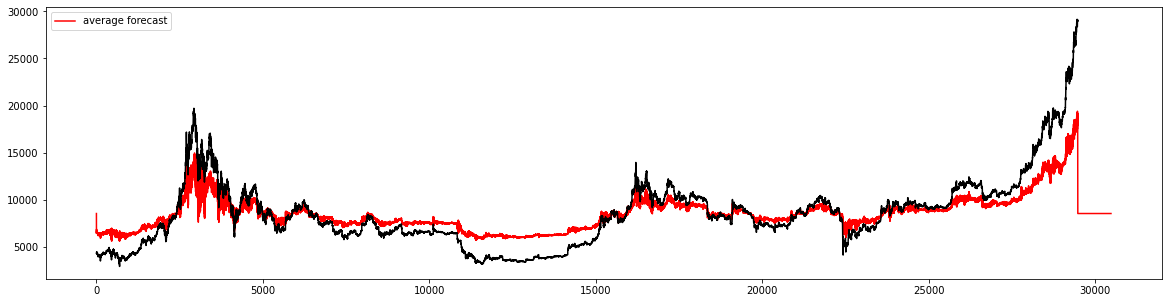

In [97]:
plt.figure(figsize=(20,5))
plt.plot(range(len(yhatH)), yhatH, c='red', label='average forecast')
plt.plot(range(len(yH)), yH, c='black')
plt.legend()
plt.show()

### datasetM

In [ ]:
modelM = ARIMA(yM, order=(0, 0, 1))
model_fit = modelM.fit()
yhatM = model_fit.predict(0, len(yM) + 1000)

In [ ]:
plt.figure(figsize=(20,5))
plt.plot(range(len(yhatM)), yhatM, c='red', label='average forecast')
plt.plot(range(len(yM)), yM, c='black')
plt.legend()
plt.show()

# Simple Exponential Smoothing (SES) 

In [98]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

### datasetH

In [118]:
modelH = SimpleExpSmoothing(yH, initialization_method="heuristic")
model_fit = modelH.fit(smoothing_level=0.01)
yhatH = model_fit.predict(0, len(yH)+ 1000)

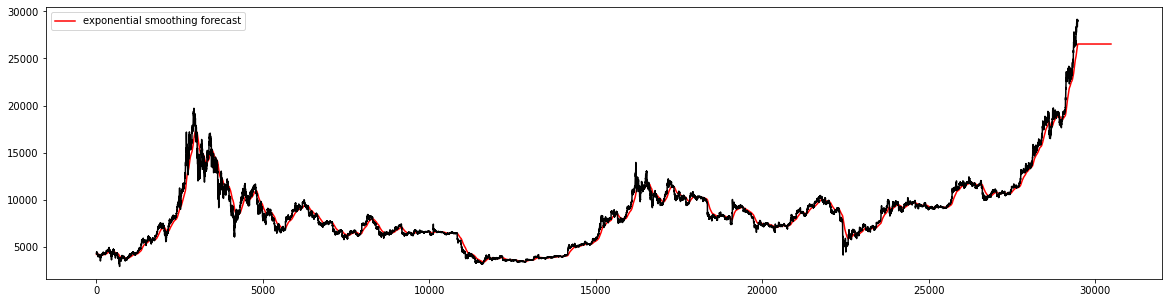

In [119]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(yhatH)), yhatH, c='red', label='exponential smoothing forecast')
plt.plot(range(0, len(yH)), yH, c='black')
plt.legend()
plt.show()

### datasetM

In [129]:
modelM = SimpleExpSmoothing(yM, initialization_method="heuristic")
model_fit = modelM.fit(smoothing_level=0.01)
yhatM = model_fit.predict(0, len(yM)+ 100000)

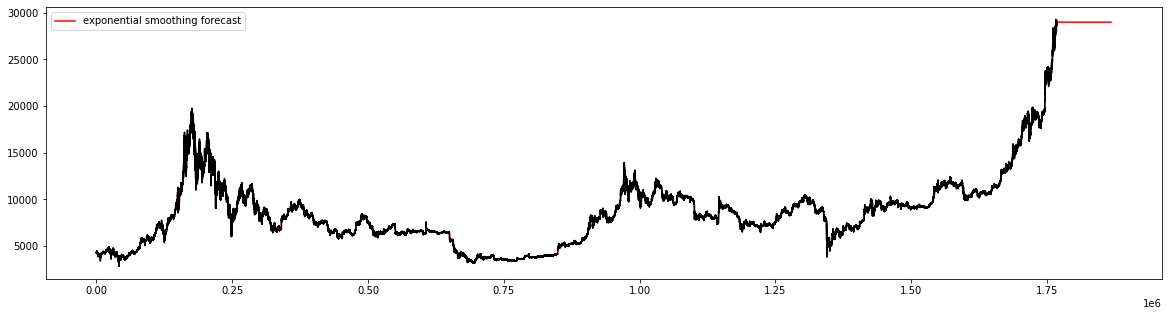

In [130]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(yhatM)), yhatM, c='red', label='exponential smoothing forecast')
plt.plot(range(0, len(yM)), yM, c='black')
plt.legend()
plt.show()

# Holt Winter’s Exponential Smoothing (HWES)

In [132]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing
import warnings

### datasetH

In [139]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    modelH = ExponentialSmoothing(yH, trend = 'add')
    model_fit = modelH.fit(smoothing_level=0.01)
yhatH = model_fit.predict(0, len(yH)+ 500)

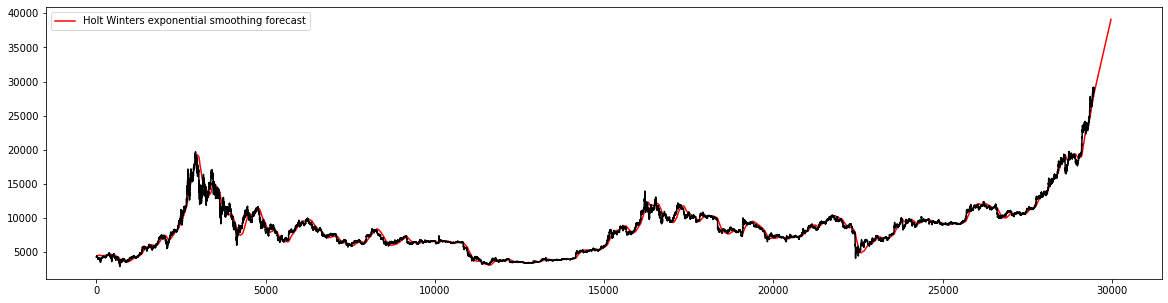

In [140]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(yhatH)), yhatH, c='red', label='Holt Winters exponential smoothing forecast')
plt.plot(range(len(yH)), yH, c='black', )
plt.legend()
plt.show()

### datasetM

In [143]:
with warnings.catch_warnings():
    warnings.filterwarnings("ignore")
    modelM = ExponentialSmoothing(yM, trend = 'add')
    model_fit = modelM.fit(smoothing_level=0.01)
yhatM = model_fit.predict(0, len(yM)+ 1000)

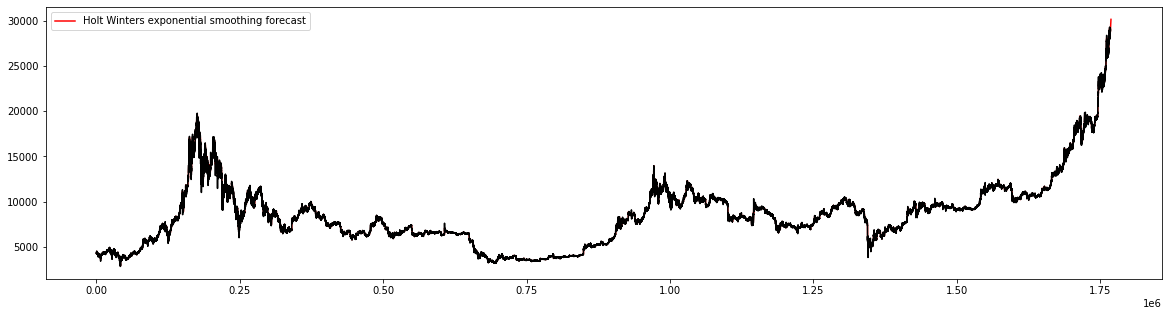

In [144]:
plt.figure(figsize=(20, 5))
plt.plot(range(len(yhatM)), yhatM, c='red', label='Holt Winters exponential smoothing forecast')
plt.plot(range(len(yM)), yM, c='black', )
plt.legend()
plt.show()

# Conclusion 

### As we can see on predictions' behavior, The autoregression (AR), The moving average (MA) and The Simple Exponential Smoothing (SES) methods are suitable for univariate time series without trend and seasonal components, while The Holt Winter’s Exponential Smoothing (HWES) metods are good for univariate time series with trend and/or seasonal components.
### Also, The autoregression method showing accurate and fast prediction result, based on a linear function of the observations, while The moving average method requires more time and effort to process data to draw accurate conclusions based on a linear function of the residual errors from a mean process.
### Whereas Simple Exponential Smoothing method result depends on exponentially weighted linear function and and inferior in accuracy to The Holt Winter’s Exponential Smoothing method because it taking trends and seasonality into account. 